In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [2]:
class Calibration(object):
    ''' Calibration matrices and utils
        3d XYZ in <label>.txt are in rect camera coord.
        2d box xy are in image2 coord
        Points in <lidar>.bin are in Velodyne coord.

        y_image2 = P^2_rect * x_rect
        y_image2 = P^2_rect * R0_rect * Tr_velo_to_cam * x_velo
        x_ref = Tr_velo_to_cam * x_velo
        x_rect = R0_rect * x_ref

        P^2_rect = [f^2_u,  0,      c^2_u,  -f^2_u b^2_x;
                    0,      f^2_v,  c^2_v,  -f^2_v b^2_y;
                    0,      0,      1,      0]
                 = K * [1|t]

        image2 coord:
         ----> x-axis (u)
        |
        |
        v y-axis (v)

        velodyne coord:
        front x, left y, up z

        rect/ref camera coord:
        right x, down y, front z

        Ref (KITTI paper): http://www.cvlibs.net/publications/Geiger2013IJRR.pdf

        TODO(rqi): do matrix multiplication only once for each projection.
    '''

    def __init__(self, calib_filepath):

        calibs = self.read_calib_file(calib_filepath)
        # Projection matrix from rect camera coord to image2 coord
        self.P = calibs['P2']
        self.P = np.reshape(self.P, [3, 4])
        # Rigid transform from Velodyne coord to reference camera coord
        self.V2C = calibs['Tr_velo_to_cam']
        self.V2C = np.reshape(self.V2C, [3, 4])
        self.C2V = inverse_rigid_trans(self.V2C)
        # Rotation from reference camera coord to rect camera coord
        self.R0 = calibs['R0_rect']
        self.R0 = np.reshape(self.R0, [3, 3])

        # Camera intrinsics and extrinsics
        self.c_u = self.P[0, 2]
        self.c_v = self.P[1, 2]
        self.f_u = self.P[0, 0]
        self.f_v = self.P[1, 1]
        self.b_x = self.P[0, 3] / (-self.f_u)  # relative
        self.b_y = self.P[1, 3] / (-self.f_v)
        
    def cart2hom(self, pts_3d):
        ''' Input: nx3 points in Cartesian
            Oupput: nx4 points in Homogeneous by pending 1
        '''
        n = pts_3d.shape[0]
        pts_3d_hom = np.hstack((pts_3d, np.ones((n, 1))))
        return pts_3d_hom

    def read_calib_file(self, filepath):
        ''' Read in a calibration file and parse into a dictionary.
        Ref: https://github.com/utiasSTARS/pykitti/blob/master/pykitti/utils.py
        '''
        data = {}
        with open(filepath, 'r') as f:
            for line in f.readlines():
                line = line.rstrip()
                if len(line) == 0: continue
                key, value = line.split(':', 1)
                # The only non-float values in these files are dates, which
                # we don't care about anyway
                try:
                    data[key] = np.array([float(x) for x in value.split()])
                except ValueError:
                    pass

        return data

    # =========================== 
    # ------- 3d to 3d ---------- 
    # =========================== 

    def project_ref_to_velo(self, pts_3d_ref):
        pts_3d_ref = self.cart2hom(pts_3d_ref)  # nx4
        return np.dot(pts_3d_ref, np.transpose(self.C2V))

    def project_rect_to_ref(self, pts_3d_rect):
        ''' Input and Output are nx3 points '''
        return np.transpose(np.dot(np.linalg.inv(self.R0), np.transpose(pts_3d_rect)))

    def project_rect_to_velo(self, pts_3d_rect):
        ''' Input: nx3 points in rect camera coord.
            Output: nx3 points in velodyne coord.
        '''
        pts_3d_ref = self.project_rect_to_ref(pts_3d_rect)
        return self.project_ref_to_velo(pts_3d_ref)


    # =========================== 
    # ------- 2d to 3d ---------- 
    # =========================== 
    def project_image_to_rect(self, uv_depth):
        ''' Input: nx3 first two channels are uv, 3rd channel
                   is depth in rect camera coord.
            Output: nx3 points in rect camera coord.
        '''
        n = uv_depth.shape[0]
        x = ((uv_depth[:, 0] - self.c_u) * uv_depth[:, 2]) / self.f_u + self.b_x
        y = ((uv_depth[:, 1] - self.c_v) * uv_depth[:, 2]) / self.f_v + self.b_y
        pts_3d_rect = np.zeros((n, 3))
        pts_3d_rect[:, 0] = x
        pts_3d_rect[:, 1] = y
        pts_3d_rect[:, 2] = uv_depth[:, 2]
        return pts_3d_rect

    def project_image_to_velo(self, uv_depth):
        pts_3d_rect = self.project_image_to_rect(uv_depth)
        return self.project_rect_to_velo(pts_3d_rect)

def inverse_rigid_trans(Tr):
    ''' Inverse a rigid body transform matrix (3x4 as [R|t])
        [R'|-R't; 0|1]
    '''
    inv_Tr = np.zeros_like(Tr)  # 3x4
    inv_Tr[0:3, 0:3] = np.transpose(Tr[0:3, 0:3])
    inv_Tr[0:3, 3] = np.dot(-np.transpose(Tr[0:3, 0:3]), Tr[0:3, 3])
    return inv_Tr

def project_depth_to_points(calib, depth, max_high):
    #rows, cols = depth.shape
    rows =  depth.shape[0] #x
    cols =  depth.shape[1] #y
    c, r = np.meshgrid(np.arange(cols), np.arange(rows))
    points = np.stack([c, r, depth[:,:,2]]) #z
    points = points.reshape((3, -1))
    points = points.T
    cloud = calib.project_image_to_velo(points)
    valid = (cloud[:, 0] >= 0) & (cloud[:, 2] < max_high)
    return cloud[valid]

In [83]:
calib_file = '/home/joonsu0109/Joon/Image_to_Point/set/000002.txt'

In [84]:
calib = Calibration(calib_file)

In [85]:
depth_map = cv2.imread('/home/joonsu0109/Joon/Image_to_Point/depth_origin.jpg') #or png

In [86]:
max_high = 1

In [87]:
depth_map

array([[[89, 89, 89],
        [68, 68, 68],
        [61, 61, 61],
        ...,
        [91, 91, 91],
        [96, 96, 96],
        [99, 99, 99]],

       [[81, 81, 81],
        [61, 61, 61],
        [54, 54, 54],
        ...,
        [89, 89, 89],
        [95, 95, 95],
        [99, 99, 99]],

       [[74, 74, 74],
        [54, 54, 54],
        [48, 48, 48],
        ...,
        [87, 87, 87],
        [93, 93, 93],
        [98, 98, 98]],

       ...,

       [[24, 24, 24],
        [24, 24, 24],
        [24, 24, 24],
        ...,
        [16, 16, 16],
        [16, 16, 16],
        [16, 16, 16]],

       [[24, 24, 24],
        [24, 24, 24],
        [24, 24, 24],
        ...,
        [16, 16, 16],
        [16, 16, 16],
        [16, 16, 16]],

       [[24, 24, 24],
        [24, 24, 24],
        [24, 24, 24],
        ...,
        [16, 16, 16],
        [16, 16, 16],
        [16, 16, 16]]], dtype=uint8)

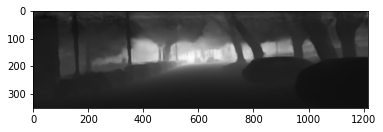

In [88]:
depth_map = (depth_map).astype(np.float32)/256
#depth_map = (depth_map*255).astype(np.uint8)
#depth_map = cv2.applyColorMap(depth_map , cv2.COLORMAP_MAGMA)
plt.imshow(depth_map)

In [89]:
depth_map

array([[[0.34765625, 0.34765625, 0.34765625],
        [0.265625  , 0.265625  , 0.265625  ],
        [0.23828125, 0.23828125, 0.23828125],
        ...,
        [0.35546875, 0.35546875, 0.35546875],
        [0.375     , 0.375     , 0.375     ],
        [0.38671875, 0.38671875, 0.38671875]],

       [[0.31640625, 0.31640625, 0.31640625],
        [0.23828125, 0.23828125, 0.23828125],
        [0.2109375 , 0.2109375 , 0.2109375 ],
        ...,
        [0.34765625, 0.34765625, 0.34765625],
        [0.37109375, 0.37109375, 0.37109375],
        [0.38671875, 0.38671875, 0.38671875]],

       [[0.2890625 , 0.2890625 , 0.2890625 ],
        [0.2109375 , 0.2109375 , 0.2109375 ],
        [0.1875    , 0.1875    , 0.1875    ],
        ...,
        [0.33984375, 0.33984375, 0.33984375],
        [0.36328125, 0.36328125, 0.36328125],
        [0.3828125 , 0.3828125 , 0.3828125 ]],

       ...,

       [[0.09375   , 0.09375   , 0.09375   ],
        [0.09375   , 0.09375   , 0.09375   ],
        [0.09375   , 0

In [90]:
depth_map.shape

(352, 1216, 3)

In [91]:
lidar = project_depth_to_points(calib, depth_map, max_high)

In [92]:
lidar.shape

(428032, 3)

In [93]:
lidar

array([[ 0.61958377,  0.35304203,  0.01868316],
       [ 0.5377787 ,  0.28357473, -0.00255963],
       [ 0.51051038,  0.26024934, -0.00964236],
       ...,
       [ 0.33555583,  0.00809645, -0.08665769],
       [ 0.33555585,  0.00800984, -0.0866586 ],
       [ 0.33555587,  0.00792322, -0.08665952]])

In [94]:
lidar = np.concatenate([lidar, np.ones((lidar.shape[0], 1))], 1)

In [95]:
lidar

array([[ 0.61958377,  0.35304203,  0.01868316,  1.        ],
       [ 0.5377787 ,  0.28357473, -0.00255963,  1.        ],
       [ 0.51051038,  0.26024934, -0.00964236,  1.        ],
       ...,
       [ 0.33555583,  0.00809645, -0.08665769,  1.        ],
       [ 0.33555585,  0.00800984, -0.0866586 ,  1.        ],
       [ 0.33555587,  0.00792322, -0.08665952,  1.        ]])

In [80]:
lidar = lidar.astype(np.float32)

In [82]:
lidar.shape

(428032, 4)

In [81]:
lidar.tofile('depth_origin.bin')